In [1]:
import torch
import json
import numpy as np
import pandas as pd
from torch import nn

from utils import get_loaders
from classifier_utils import HateSpeechClassifier, forward_back_prop, \
                             train_classifier, batch_test, plot_confusion_matrices

tweets = np.load("data/tweets.npy")
labels = np.load("data/hate_original.npy")

with open('vocab_to_int.json', 'r') as fp:
    vocab_to_int = json.load(fp)

with open('int_to_vocab.json', 'r') as fp:
    int_to_vocab = json.load(fp)
    
train_on_gpu = torch.cuda.is_available()
print("Using GPU." if train_on_gpu else "Using CPU.")

Using GPU.


### Creating the Training, Validation, and Test Sets

In [2]:
batch_size = 80
train_loader, valid_loader, test_loader = get_loaders(tweets, labels, 
                                                      train_frac=0.8, remain_split_frac=0.5, 
                                                      batch_size=batch_size)

			Feature Shapes:
Train set: 		(19826, 100) 
Validation set: 	(2478, 100) 
Test set: 		(2479, 100)


In [3]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([80, 100])
Sample input: 
 tensor([[    0,     0,     0,  ..., 13676,  6990, 16880],
        [    0,     0,     0,  ..., 14145,  9372, 15533],
        [    0,     0,     0,  ..., 20675, 10523, 18299],
        ...,
        [    0,     0,     0,  ...,  8693,  3101, 14220],
        [    0,     0,     0,  ..., 20841,  3509, 19765],
        [    0,     0,     0,  ...,  2909,  2909,  2909]], dtype=torch.int32)

Sample label size:  torch.Size([80])
Sample label: 
 tensor([2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 2, 1, 1, 1, 2, 1])


# 1. Replication: Hemker (2018)

### Hyperparameters

In [4]:
sequence_length = tweets.shape[1]  # number of words in a sequence
num_epochs = 10
learning_rate = 0.01
momentum = 0.7
vocab_size = len(vocab_to_int)
output_size = pd.Series(labels).nunique()
embedding_dim = 300
hidden_dim = 256
n_layers = 1
show_every_n_batches = 50
cnn_params = (256, 25, 9, 3) # out_channels, kernel_size, stride, padding
pool_params = (4, 2, 0)

### Model Instantiation

In [ ]:
model = HateSpeechClassifier(vocab_size, output_size, embedding_dim, 
                             cnn_params, pool_params, hidden_dim, n_layers,
                             p_dropout = 0,
                             embedding_path="glove/glove.42B.300d.txt", 
                             vocab_to_int=vocab_to_int, train_on_gpu=train_on_gpu)

if train_on_gpu:
    model.cuda()

Setting pretrained embedding weights...


### Train network

In [6]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [7]:
model = train_classifier(model, batch_size, optimizer, criterion, num_epochs, train_loader, valid_loader,
                         show_every_n_batches=show_every_n_batches)

Training for 10 epoch(s)...
Epoch: 1/10. 	Batch: 50/248.	 Avg. Training Loss: 1.856294195652008
Epoch: 1/10. 	Batch: 100/248.	 Avg. Training Loss: 1.4079750180244446
Epoch: 1/10. 	Batch: 150/248.	 Avg. Training Loss: 1.2053488653898239
Epoch: 1/10. 	Batch: 200/248.	 Avg. Training Loss: 1.0840946029126644
Epoch: 1 	Training Loss: 1.048205 	Validation Loss: 0.822882 	 Accuracy: 77.250000

Epoch: 2/10. 	Batch: 50/248.	 Avg. Training Loss: 0.7798457258939743
Epoch: 2/10. 	Batch: 100/248.	 Avg. Training Loss: 0.8407374864816666
Epoch: 2/10. 	Batch: 150/248.	 Avg. Training Loss: 0.8002206651369731
Epoch: 2/10. 	Batch: 200/248.	 Avg. Training Loss: 0.7937785339355469
Epoch: 2 	Training Loss: 0.811580 	Validation Loss: 0.645776 	 Accuracy: 77.625000

Epoch: 3/10. 	Batch: 50/248.	 Avg. Training Loss: 0.7841263580322265
Epoch: 3/10. 	Batch: 100/248.	 Avg. Training Loss: 0.7912246978282929
Epoch: 3/10. 	Batch: 150/248.	 Avg. Training Loss: 0.8216935082276662
Epoch: 3/10. 	Batch: 200/248.	 Avg. Tr

### Test network

In [8]:
test_loss, test_acc, y_true, y_pred = batch_test(model, batch_size, test_loader, criterion, prnt=True)

Test loss: 2.133
Test accuracy: 15.9%


Confusion matrix, without normalization
Normalized confusion matrix


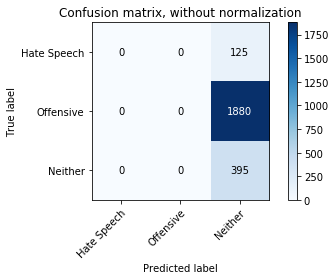

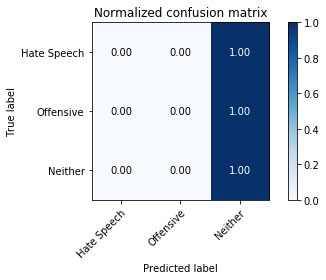

In [9]:
plot_confusion_matrices(y_true, y_pred)

In [10]:
del model
torch.cuda.empty_cache()

# 2. Learning Rate: 0.01 → 0.001

### Hyperparameters

In [4]:
sequence_length = tweets.shape[1]  # number of words in a sequence
num_epochs = 10
learning_rate = 0.001
momentum = 0.7
vocab_size = len(vocab_to_int)
output_size = pd.Series(labels).nunique()
embedding_dim = 300
hidden_dim = 256
n_layers = 1
show_every_n_batches = 50
cnn_params = (256, 25, 9, 3) # out_channels, kernel_size, stride, padding
pool_params = (4, 2, 0)

### Model Instantiation

In [5]:
model = HateSpeechClassifier(vocab_size, output_size, embedding_dim, 
                             cnn_params, pool_params, hidden_dim, n_layers,
                             p_dropout = 0,
                             embedding_path="glove/glove.42B.300d.txt", 
                             vocab_to_int=vocab_to_int, train_on_gpu=train_on_gpu)

if train_on_gpu:
    model.cuda()

### Train network

In [6]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [7]:
model = train_classifier(model, batch_size, optimizer, criterion, num_epochs, train_loader, valid_loader,
                         show_every_n_batches=show_every_n_batches, save_path="temp_model.pth")

Training for 10 epoch(s)...
Epoch: 1/10. 	Batch: 50/248.	 Avg. Training Loss: 0.5522384712100029
Epoch: 1/10. 	Batch: 100/248.	 Avg. Training Loss: 0.465042033046484
Epoch: 1/10. 	Batch: 150/248.	 Avg. Training Loss: 0.4230298986037572
Epoch: 1/10. 	Batch: 200/248.	 Avg. Training Loss: 0.3985329283773899
Epoch: 1 	Training Loss: 0.382028 	Validation Loss: 0.286332 	 Accuracy: 90.208333

Validation loss decreased (inf --> 0.286332).  Saving model ...

Epoch: 2/10. 	Batch: 50/248.	 Avg. Training Loss: 0.23334313824772834
Epoch: 2/10. 	Batch: 100/248.	 Avg. Training Loss: 0.24487640269100666
Epoch: 2/10. 	Batch: 150/248.	 Avg. Training Loss: 0.24139328474799793
Epoch: 2/10. 	Batch: 200/248.	 Avg. Training Loss: 0.24184272423386574
Epoch: 2 	Training Loss: 0.243735 	Validation Loss: 0.289865 	 Accuracy: 90.083333

Epoch: 3/10. 	Batch: 50/248.	 Avg. Training Loss: 0.17070538505911828
Epoch: 3/10. 	Batch: 100/248.	 Avg. Training Loss: 0.16605306293815375
Epoch: 3/10. 	Batch: 150/248.	 Avg. T

In [7]:
# Load saved model
model.load_state_dict(torch.load("temp_model.pth"))

<All keys matched successfully>

### Test network

In [8]:
test_loss, test_acc, y_true, y_pred = batch_test(model, batch_size, test_loader, criterion, prnt=True)

Test loss: 0.227
Test accuracy: 89.4%


Confusion matrix, without normalization
Normalized confusion matrix


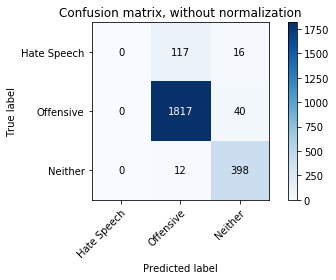

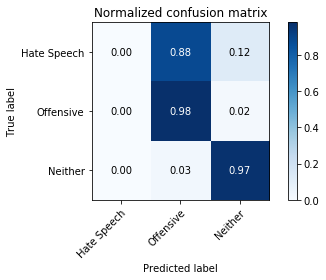

In [9]:
plot_confusion_matrices(y_true, y_pred)

In [18]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average="weighted")

0.8967537496794279

In [11]:
del model
torch.cuda.empty_cache()